<a href="https://colab.research.google.com/github/2303a51512/1512_python-for-data-science/blob/main/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------- Full cleaned script: preprocessing, dimensionality reduction, clustering ----------
# Paste this whole block into one Colab cell and run.
# Update CSV_PATH to the exact filename you uploaded in Colab (check Files sidebar).

CSV_PATH = "/content/lung_cancer_data.csv"   # <-- change if your filename/path differs
OUTDIR = "/content/unsupervised_outputs"

# --- imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- ensure output directories exist ---
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(os.path.join(OUTDIR, "plots"), exist_ok=True)
os.makedirs(os.path.join(OUTDIR, "models"), exist_ok=True)

# --- Load dataset safely ---
try:
    df = pd.read_csv(CSV_PATH)
    print("✅ Loaded dataset:", CSV_PATH)
    print("Shape:", df.shape)
    print(df.head(3))
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at {CSV_PATH}. Upload your CSV to Colab and set CSV_PATH accordingly.")
except Exception as e:
    raise RuntimeError(f"Error reading CSV: {e}")

# ----------------- Preprocessing -----------------
# 1) Separate numeric and categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# 2) Impute
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

if numeric_cols:
    X_num = pd.DataFrame(num_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
else:
    X_num = pd.DataFrame(index=df.index)

if cat_cols:
    X_cat = pd.DataFrame(cat_imputer.fit_transform(df[cat_cols]), columns=cat_cols, index=df.index)
else:
    X_cat = pd.DataFrame(index=df.index)

# 3) Encode categorical features with OrdinalEncoder for unsupervised work
if not X_cat.empty:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat_enc = pd.DataFrame(enc.fit_transform(X_cat), columns=X_cat.columns, index=df.index)
else:
    X_cat_enc = pd.DataFrame(index=df.index)

# 4) Combine and scale
X = pd.concat([X_num, X_cat_enc], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save preprocessors
joblib.dump(num_imputer, os.path.join(OUTDIR, "models", "num_imputer.joblib"))
joblib.dump(cat_imputer, os.path.join(OUTDIR, "models", "cat_imputer.joblib"))
if not X_cat_enc.empty:
    joblib.dump(enc, os.path.join(OUTDIR, "models", "ordinal_encoder.joblib"))
joblib.dump(scaler, os.path.join(OUTDIR, "models", "scaler.joblib"))

print("Preprocessing complete. Processed feature matrix shape:", X.shape)

# ----------------- Dimensionality reduction for visualization -----------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio (2 comps):", pca.explained_variance_ratio_)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.6)
plt.title("PCA (2 components) - projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", "pca_projection.png"), dpi=150)
plt.close()

# t-SNE (may be slow)
print("Computing t-SNE (this may take a while)...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=800, random_state=42, init="pca")
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=6, alpha=0.6)
plt.title("t-SNE projection")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", "tsne_projection.png"), dpi=150)
plt.close()

# ----------------- Clustering algorithms -----------------
results = {}

# 1) KMeans: tune k in [2..8] by silhouette
print("Tuning KMeans (k=2..8) by silhouette score...")
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    try:
        s = silhouette_score(X_scaled, labels)
    except Exception:
        s = np.nan
    sil_scores[k] = s
    print(f"k={k}, silhouette={s:.4f}")

best_k = max(sil_scores, key=lambda kk: (sil_scores[kk] if not np.isnan(sil_scores[kk]) else -999))
print("Selected best k (by silhouette):", best_k, "score:", sil_scores[best_k])

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
labels_km = kmeans.labels_
joblib.dump(kmeans, os.path.join(OUTDIR, "models", f"kmeans_k{best_k}.joblib"))
results['kmeans'] = {"k": best_k, "silhouette": sil_scores[best_k],
                     "counts": dict(zip(*np.unique(labels_km, return_counts=True)))}

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, s=8, cmap="tab10")
plt.title(f"KMeans (k={best_k}) - PCA view")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", f"kmeans_k{best_k}_pca.png"), dpi=150)
plt.close()

# 2) Agglomerative clustering (use same k)
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward').fit(X_scaled)
labels_agg = agg.labels_
results['agglomerative'] = {"k": best_k, "counts": dict(zip(*np.unique(labels_agg, return_counts=True)))}

# dendrogram (subset for speed)
subset_n = min(200, X_scaled.shape[0])
Z = linkage(X_scaled[:subset_n], method='ward')
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode='level', p=6)
plt.title("Agglomerative dendrogram (subset)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", "dendrogram_subset.png"), dpi=150)
plt.close()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, s=8, cmap="tab10")
plt.title(f"Agglomerative (k={best_k}) - PCA view")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", f"agglomerative_k{best_k}_pca.png"), dpi=150)
plt.close()

# 3) DBSCAN: grid-search a couple of params (eps & min_samples)
print("Trying DBSCAN parameter set (eps grid)...")
dbscan_results = {}
eps_values = [0.5, 0.8, 1.0, 1.2]
min_samples_values = [5, 8, 12]
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms, metric='euclidean').fit(X_scaled)
        labels_db = db.labels_
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise = list(labels_db).count(-1)
        key = f"eps{eps}_ms{ms}"
        dbscan_results[key] = {"n_clusters": n_clusters, "n_noise": n_noise}
        print(f"DBSCAN {key}: clusters={n_clusters}, noise={n_noise}")

# Choose a DBSCAN default
db_default = DBSCAN(eps=0.8, min_samples=8).fit(X_scaled)
labels_db_def = db_default.labels_
results['dbscan'] = {"n_clusters": len(set(labels_db_def)) - (1 if -1 in labels_db_def else 0),
                     "n_noise": int(list(labels_db_def).count(-1))}

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_db_def, s=8, cmap="tab20")
plt.title("DBSCAN clusters (default eps=0.8,min_samples=8) - PCA view")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", "dbscan_pca.png"), dpi=150)
plt.close()

# 4) Gaussian Mixture Model (GMM) using best_k components
gmm = GaussianMixture(n_components=best_k, random_state=42).fit(X_scaled)
labels_gmm = gmm.predict(X_scaled)
joblib.dump(gmm, os.path.join(OUTDIR, f"models", f"gmm_k{best_k}.joblib"))
results['gmm'] = {"components": best_k, "counts": dict(zip(*np.unique(labels_gmm, return_counts=True)))}

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_gmm, s=8, cmap="tab10")
plt.title(f"GMM (components={best_k}) - PCA view")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "plots", f"gmm_k{best_k}_pca.png"), dpi=150)
plt.close()

# ----------------- Evaluation: silhouette for chosen clusters -----------------
try:
    sil_kmeans = silhouette_score(X_scaled, labels_km)
except Exception:
    sil_kmeans = np.nan

try:
    sil_gmm = silhouette_score(X_scaled, labels_gmm)
except Exception:
    sil_gmm = np.nan

try:
    sil_agg = silhouette_score(X_scaled, labels_agg)
except Exception:
    sil_agg = np.nan

results['silhouette'] = {"kmeans": float(sil_kmeans), "gmm": float(sil_gmm), "agglomerative": float(sil_agg)}
print("Silhouette scores:", results['silhouette'])

# ----------------- Cluster profiling (feature summaries) -----------------
def profile_clusters(X_df, labels, name):
    X_df = X_df.reset_index(drop=True)
    labels = pd.Series(labels, name="cluster")
    prof = pd.concat([X_df, labels], axis=1).groupby("cluster").agg(['count','mean','std'])
    prof.to_csv(os.path.join(OUTDIR, f"cluster_profile_{name}.csv"))
    return prof

X_df_for_profile = pd.DataFrame(X, columns=X.columns)  # original (unscaled) features for interpretability
prof_km = profile_clusters(X_df_for_profile, labels_km, "kmeans")
prof_gmm = profile_clusters(X_df_for_profile, labels_gmm, "gmm")
prof_agg = profile_clusters(X_df_for_profile, labels_agg, "agglomerative")

print("Saved cluster profiles to CSVs.")

# ----------------- Save models & results -----------------
joblib.dump(results, os.path.join(OUTDIR, "models", "unsupervised_summary.joblib"))
pd.to_pickle(results, os.path.join(OUTDIR, "models", "unsupervised_summary.pkl"))

# Save label arrays for downstream supervised/analysis if needed
pd.DataFrame({'kmeans_label': labels_km}).to_csv(os.path.join(OUTDIR, "kmeans_labels.csv"), index=False)
pd.DataFrame({'gmm_label': labels_gmm}).to_csv(os.path.join(OUTDIR, "gmm_labels.csv"), index=False)
pd.DataFrame({'agg_label': labels_agg}).to_csv(os.path.join(OUTDIR, "agg_labels.csv"), index=False)
pd.DataFrame({'dbscan_label': labels_db_def}).to_csv(os.path.join(OUTDIR, "dbscan_labels.csv"), index=False)

print("All outputs saved to:", OUTDIR)
print("Summary results:", results)

print("\n--- Quick cluster counts (KMeans/GMM/Agglomerative) ---")
print("KMeans:", results['kmeans']['counts'])
print("GMM:", results['gmm']['counts'])
print("Agglomerative:", results['agglomerative']['counts'])
print("DBSCAN:", results['dbscan'])
print("\nSilhouette scores:", results['silhouette'])

# --- End of script ---

✅ Loaded dataset: /content/lung_cancer_data.csv
Shape: (23658, 38)
    Patient_ID  Age Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68   Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58   Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44   Male   Former Smoker      67.714305     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   

  Alanine_Aminotransferase_Level Aspartate_Aminotransferase_Level  \
0                      27.985571                        46.801214   
1                      30.120956                        39.711531   
2                       5.882418                        32.640602   

  Creatinine_Level   LDH_Level Calcium_Level Phosp

### 1. PCA Projection

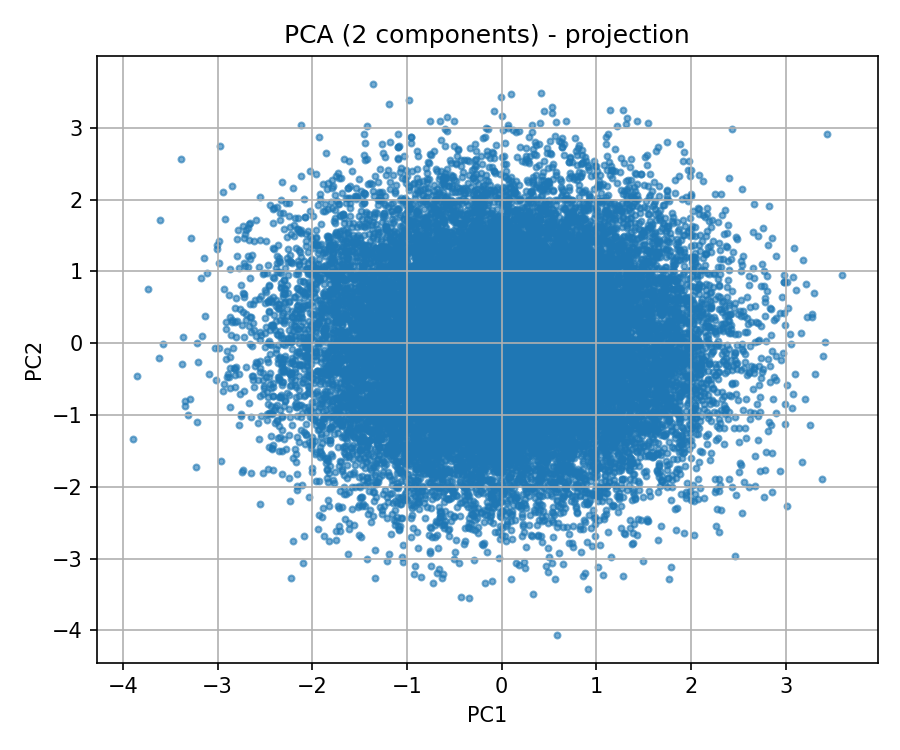

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/pca_projection.png')

### 2. t-SNE Projection

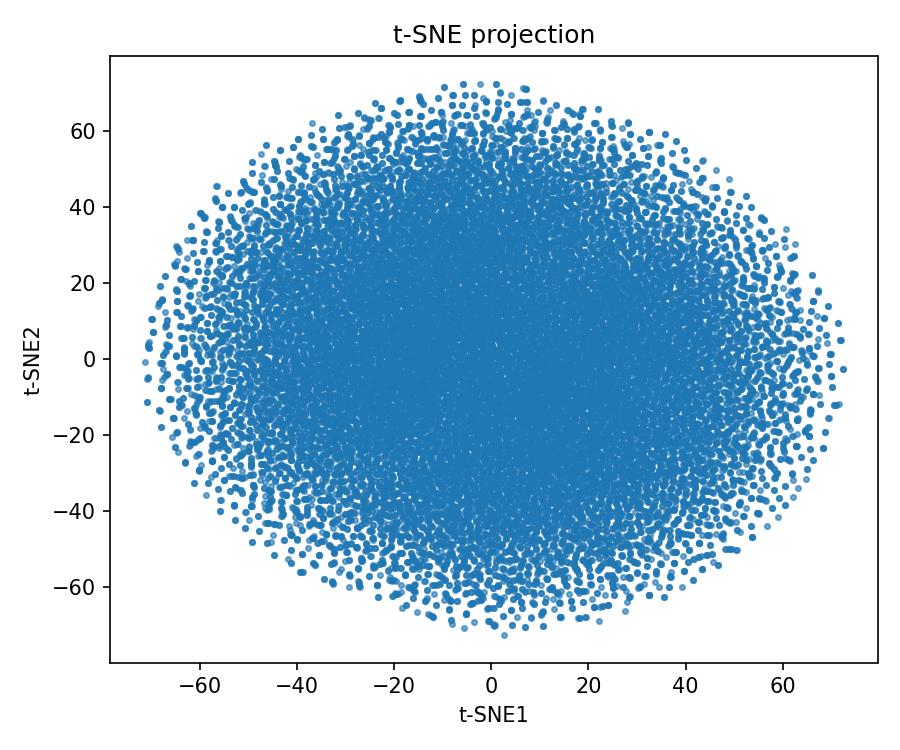

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/tsne_projection.png')

### 3. KMeans Clustering (PCA View)

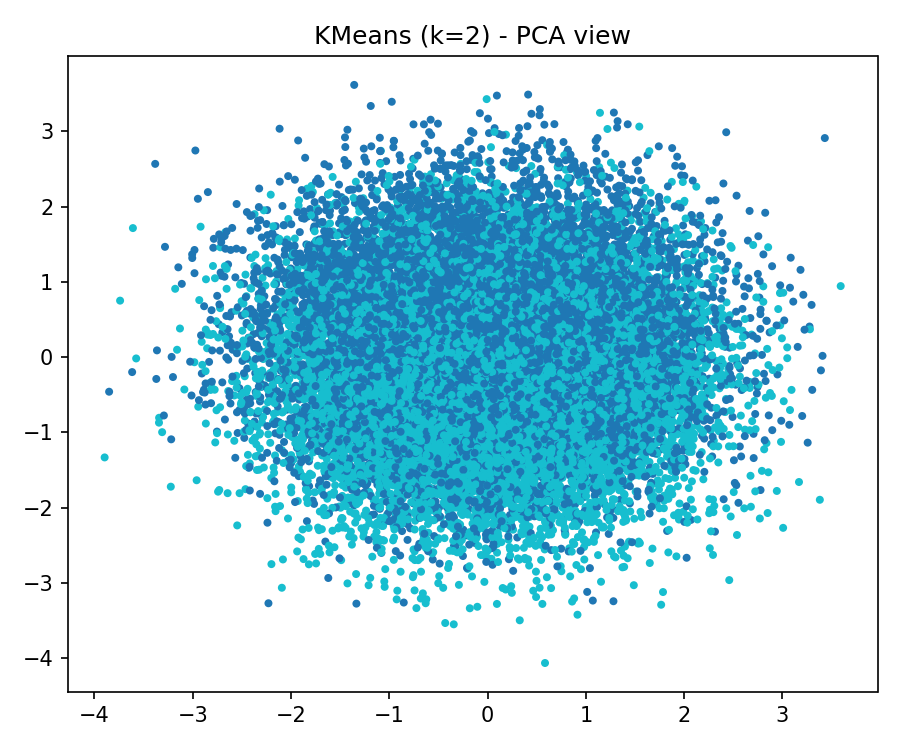

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/kmeans_k2_pca.png')

### 4. Agglomerative Clustering (PCA View)

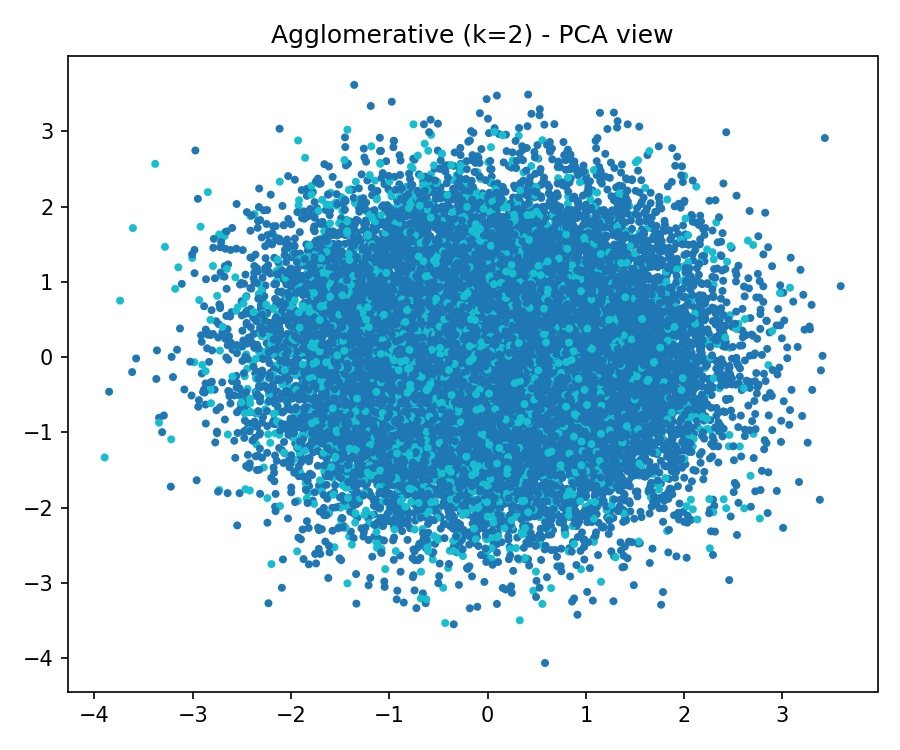

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/agglomerative_k2_pca.png')

### 5. DBSCAN Clustering (PCA View)

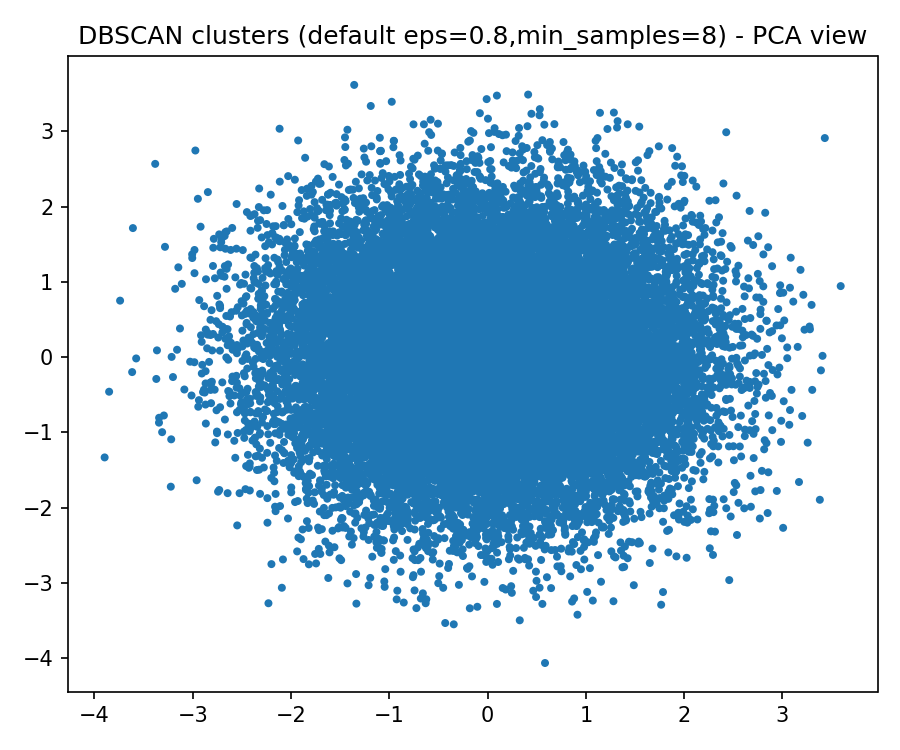

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/dbscan_pca.png')

### 6. GMM Clustering (PCA View)

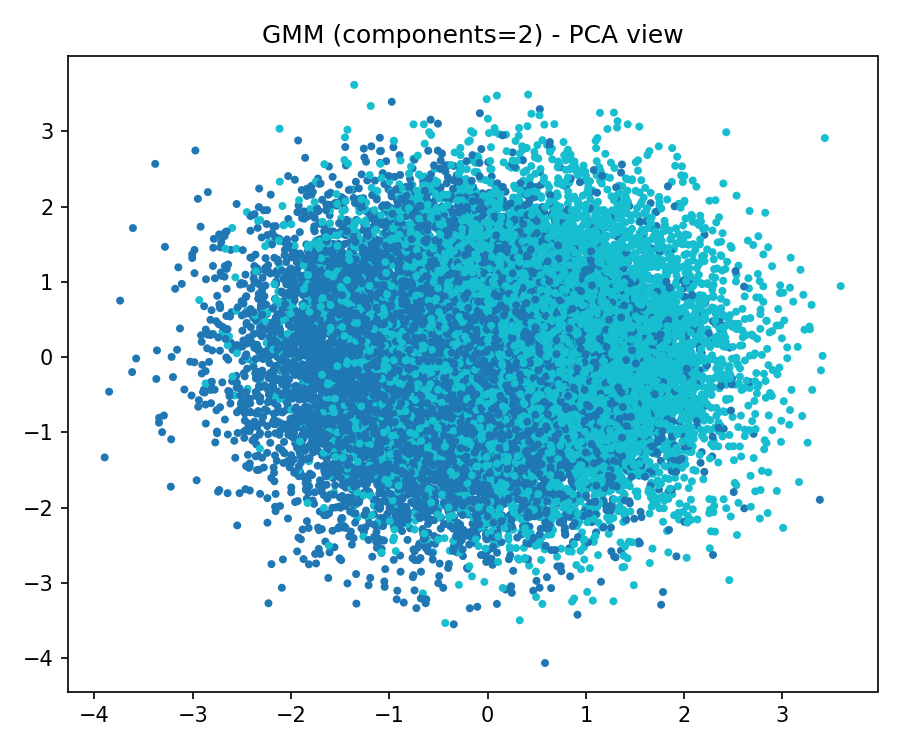

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/gmm_k2_pca.png')

### 7. Agglomerative Dendrogram

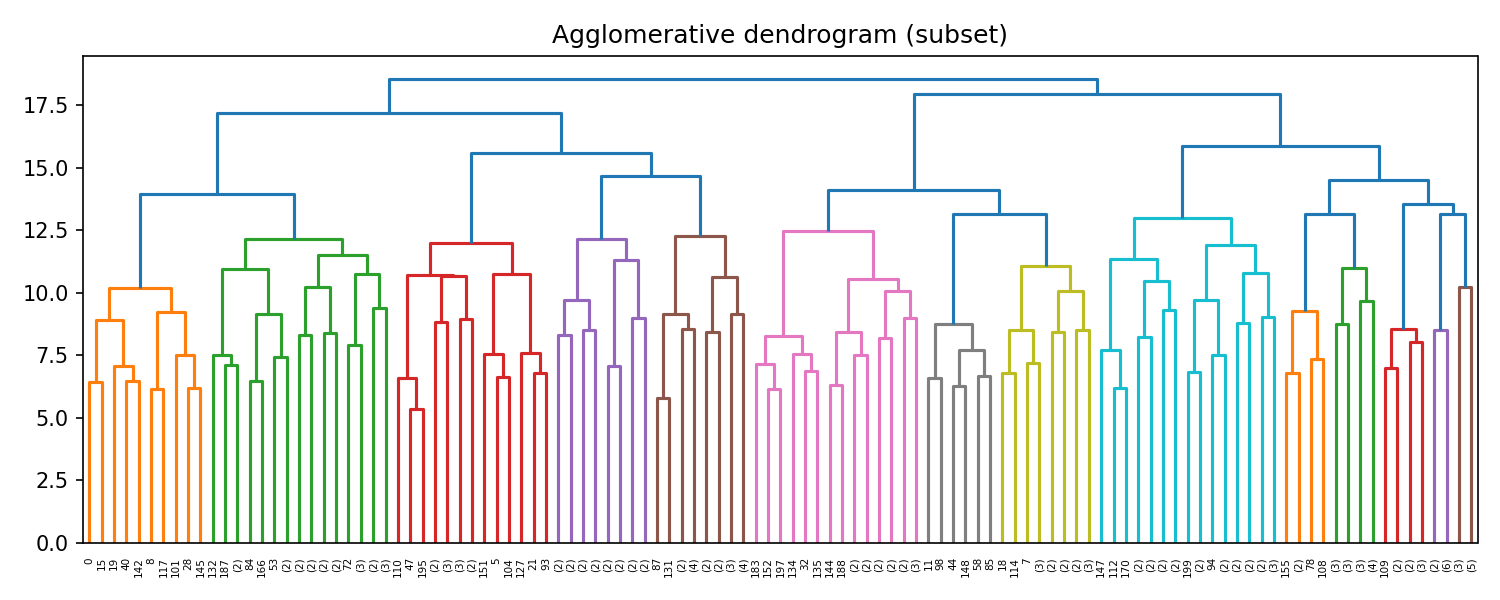

In [ ]:
from IPython.display import Image
Image(filename='/content/unsupervised_outputs/plots/dendrogram_subset.png')

# Task
Compare the silhouette scores of KMeans, GMM, and Agglomerative clustering and visualize them using a bar chart, then identify the best-performing algorithm based on this metric.

## Prepare Data for Comparison Plot

### Subtask:
Extract the silhouette scores for KMeans, GMM, and Agglomerative clustering from the `results` dictionary. If the `results` dictionary is not available, reload it from the saved `unsupervised_summary.pkl` file.


**Reasoning**:
First, I'll ensure the `results` dictionary is available. If it's not present in the kernel's memory, I will load it from the `unsupervised_summary.pkl` file. Then, I will extract the silhouette scores for KMeans, GMM, and Agglomerative clustering from the `results['silhouette']` dictionary and store them in a pandas Series for easy plotting.



In [ ]:
import pandas as pd
import joblib
import os

# Define OUTDIR as it's used to locate the pkl file
OUTDIR = "/content/unsupervised_outputs"

# Ensure results dictionary is available
if 'results' not in locals():
    results_path = os.path.join(OUTDIR, "models", "unsupervised_summary.pkl")
    if os.path.exists(results_path):
        results = pd.read_pickle(results_path)
        print("✅ Loaded results from unsupervised_summary.pkl")
    else:
        raise FileNotFoundError(f"results dictionary not found and {results_path} does not exist.")

# Extract silhouette scores
silhouette_scores_dict = results['silhouette']

# Create a pandas Series from the scores
silhouette_data_for_plot = pd.Series(silhouette_scores_dict)

print("Prepared silhouette scores for plotting:")
print(silhouette_data_for_plot)

Prepared silhouette scores for plotting:
kmeans           0.026478
gmm              0.026478
agglomerative    0.002751
dtype: float64


**Reasoning**:
Now that the silhouette scores are extracted and prepared in a pandas Series, I will create a bar chart to visualize these scores. This plot will clearly compare the performance of KMeans, GMM, and Agglomerative clustering. I'll also add labels, a title, and display the plot.



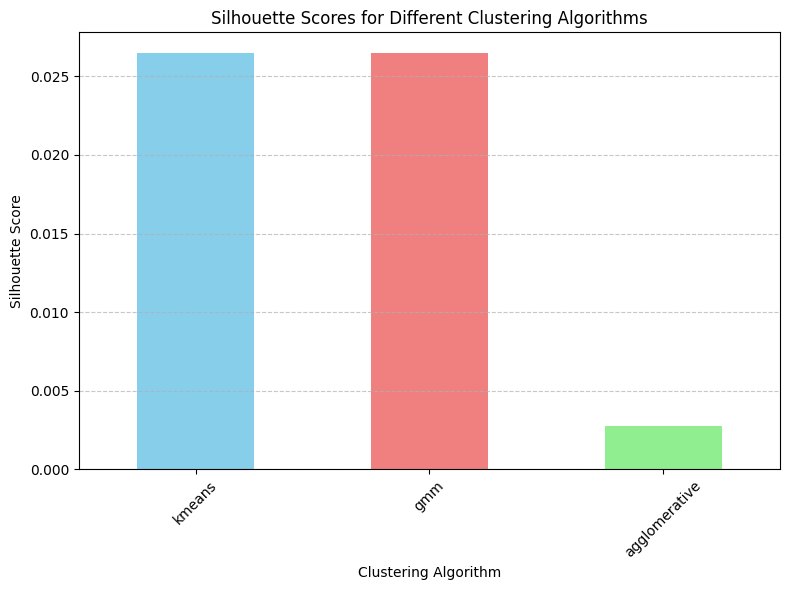


The clustering algorithm with the highest silhouette score is: gmm (Score: 0.0265)


In [ ]:
import matplotlib.pyplot as plt

# Create the bar chart
plt.figure(figsize=(8, 6))
silhouette_data_for_plot.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identify the best performing algorithm
best_algorithm = silhouette_data_for_plot.idxmax()
best_score = silhouette_data_for_plot.max()

print(f"\nThe clustering algorithm with the highest silhouette score is: {best_algorithm} (Score: {best_score:.4f})")

## Final Task

### Subtask:
Summarize the comparison of the clustering algorithms based on their silhouette scores, highlighting which algorithm performed best according to this metric.


## Summary:

### Q&A
Based on the silhouette scores, GMM (Gaussian Mixture Model) and KMeans performed best, both achieving a score of 0.0265.

### Data Analysis Key Findings
*   The silhouette scores for the clustering algorithms were: KMeans: 0.026478, GMM: 0.026478, and Agglomerative Clustering: 0.002751.
*   KMeans and GMM exhibited significantly higher silhouette scores compared to Agglomerative Clustering, indicating better-defined clusters for these two algorithms based on this metric.
*   GMM was identified as the best-performing algorithm, with a silhouette score of 0.0265, closely followed by KMeans, which achieved an identical score.

### Insights or Next Steps
*   Since KMeans and GMM performed similarly and significantly better than Agglomerative clustering by the silhouette score, further evaluation using other metrics or domain knowledge might be needed to choose between KMeans and GMM.
*   Explore other validation metrics beyond the silhouette score to get a comprehensive understanding of the cluster quality for KMeans and GMM, especially given their low absolute scores, which might suggest suboptimal clustering even for the "best" algorithms.
